# Stat-Win Correlation analysis: Team

> by Imt of NYXL (imt@andbox.com)

# Data Preparation

In [1]:
import os
import pandas as pd 
from tqdm import tqdm
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_ind_from_stats

## 0. Preprocess simple PHS files

> define `is_all_time` == True or False

> if `is_all_time` == False, then specify `phs_name = phs_list[#]`

> add `is_match_winner` and `is_map_winner` features into the dataframe

In [2]:
# File path of prepared new_phs
path = "./data/"
phs_list = os.listdir(path)
phs_list = [file_name for file_name in phs_list if file_name.endswith(".csv")]

# choose all time or specific season
is_all_time = False # set True if target data is all seasons data

if is_all_time == True:
    li = []
    for phs_name in phs_list:
        new_phs = pd.read_csv(f'{path}{phs_name}')
        li.append(new_phs)
    new_phs = pd.concat(li, axis=0, ignore_index=True)
    all_seasons = True

else:
    phs_name = phs_list[11] # set index of target csv file
    print(f'selected phs: {phs_name}')
    new_phs = pd.read_csv(f'{path}{phs_name}')
    all_seasons = False

# Add 'is_match_winner' feature
def match_winner(df):
    '''
    args, get a dataframe, expected to be phs with selected features
    targets, winner = 1; loser = 0
    '''
    if df['match_winner'] == df['team_name']: #there's 'team' column in 2018 data 
        return 1
    elif df['match_winner'] == 'draw':
        return -1
    else:
        return 0

new_phs['is_match_winner'] = new_phs.apply(match_winner, axis = 1)

# Add 'is_map_winner' feature
def map_winner(df):
    '''
    args, get a dataframe, expected to be phs with selected features
    targets, winner = 1; loser = 0; draw = -1
    '''
    if df['map_winner'] == df['team_name']:
        return 1
    elif df['map_winner'] == 'draw':
        return -1
    else:
        return 0

new_phs['is_map_winner'] = new_phs.apply(map_winner, axis = 1)

selected phs: new_phs_2020_2.csv


<AxesSubplot:ylabel='hero_name'>

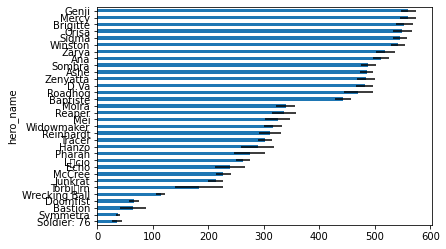

In [3]:
# data collection
df = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount', 'is_map_winner']]
df = df[df['stat_name'] == 'Time Played']

df = df.drop(df[df['hero_name']=='All Heroes'].index)
df = df.groupby(['hero_name'])['stat_amount'].agg(['mean', 'std', 'count', 'sem'])

df.sort_values(by=['mean'], inplace=True)
df['mean'].plot.barh(xerr=df['sem'])

## 1. Feature Engineering

> define a `target_hero` = <hero name>

> remove features of `remove_feature`

> specify the data type `X, y = data_type[#]` among 0:'real', 1:'norm' or 2:'10min avg' ...

In [4]:
# select targets
# Team
target_team = 'All' 
'''
'Houston Outlaws' 'Paris Eternal' 'Los Angeles Gladiators'
 'New York Excelsior' 'Guangzhou Charge' 'Philadelphia Fusion'
 'Shanghai Dragons' 'Vancouver Titans' 'Toronto Defiant'
 'Washington Justice' 'Dallas Fuel' 'London Spitfire'
 'San Francisco Shock' 'Seoul Dynasty' 'Chengdu Hunters'
 'Los Angeles Valiant' 'Boston Uprising' 'Atlanta Reign' 'Hangzhou Spark'
 'Florida Mayhem'
'''

# Player
target_player = 'All'

# Hero
target_hero = 'Genji'
'''
'All Heroes' 'Orisa' 'Winston' 'L첬cio' 'Mercy' 'Hanzo' 'Junkrat' 'Tracer'
 'Roadhog' 'Soldier: 76' 'Zenyatta' 'D.Va' 'Widowmaker' 'Zarya'
 'Reinhardt' 'McCree' 'Pharah' 'Brigitte' 'Genji' 'Sombra' 'Reaper'
 'Doomfist' 'Bastion' 'Mei' 'Moira' 'Torbj철rn' 'Ana' 'Symmetra' 'Sigma'
 'Baptiste' 'Wrecking Ball' 'Ashe' 'Echo'
'''

# data collection
df = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount', 'is_map_winner']]

# data selection
if target_team != 'All':
    df = df[df['team_name'] == target_team]

if target_player != 'All':
    df = df[df['player_name'] == target_player]

if target_hero != 'All':
    df = df[df['hero_name'] == target_hero]
else:
    target_hero = 'All Heroes'
    df = df[df['hero_name'] == target_hero]

df['is_map_winner'].dropna(axis=0, inplace=True) # drop nan values
df.drop(df[df['is_map_winner'] == -1].index , inplace=True) # drop draw

df = df.groupby(['esports_match_id', 'player_name', 'is_map_winner', 'map_name', 'stat_name'])[['stat_amount', 'is_map_winner']].mean()
df = df.unstack()

df = df.xs('stat_amount', level=0, axis=1)

# Remove irrelevant features
remove_feature = ['Average Time Alive', 'Damage Done', 'Knockback Kills', 'Teleporter Pads Destroyed', 'Time Alive', 'Turrets Destroyed', 'Ultimates Earned - Fractional'] # remove features seems to be irrelevant
df = df[df.columns.difference(remove_feature)]

# Data cleansing
df.fillna(0, inplace=True)
df = df.stack()
df = df.groupby(['esports_match_id', 'is_map_winner', 'map_name', 'stat_name']).mean()
df = df.unstack()

# check nan values in df
print(f'nan values in df: {df.isnull().sum().sum()}')
display(df.head()) # combined dataframe

# normalize to 10 min average
df_10min = df[df.columns.difference(['is_map_winner'])].div(df['Time Played'], axis=0)
df_10min = df_10min * 600 # 10 min avg
df_10min = df_10min.dropna(axis=0) # cleansing nan values

print(f'num nan values in df_10min: {df_10min.isnull().sum().sum()}')
display(df_10min)

df_10min_0 = df_10min.xs(0, level=1)
df_10min_1 = df_10min.xs(1, level=1)

df_10min_0['is_map_winner'] = 0
df_10min_1['is_map_winner'] = 1

df_10min = pd.concat([df_10min_0, df_10min_1])

# Data transform
X_10min = df_10min.drop(['is_map_winner'], axis=1)
y_10min = df_10min['is_map_winner']

# Select X, y data type
'''
0: 10min
'''
# save data type here
data_type = []
data_type.append([X_10min, y_10min])

X, y = data_type[0] # select data type with index

nan values in df: 0


stat_name                                             All Damage Done  \
esports_match_id is_map_winner map_name                                 
34776            1             Route 66                      0.000000   
34778            0             Busan                      8729.176163   
                               Eichenwalde               17886.309340   
                               Watchpoint: Gibraltar      3926.762159   
                 1             Busan                      3611.240719   

stat_name                                             Assists  \
esports_match_id is_map_winner map_name                         
34776            1             Route 66                   0.0   
34778            0             Busan                      1.0   
                               Eichenwalde               10.0   
                               Watchpoint: Gibraltar      0.0   
                 1             Busan                      5.0   

stat_name                                             Barrier Damage Done  \
esports_match_id is_map_winner map_name                                     
34776            1             Route 66                          0.000000   
34778            0             Busan                          3927.491804   
                               Eichenwalde                    7237.977391   
                               Watchpoint: Gibraltar          1940.000000   
                 1             Busan                           404.075301   

stat_name                                             Critical Hit Accuracy  \
esports_match_id is_map_winner map_name                                       
34776            1             Route 66                            0.000000   
34778            0             Busan                               0.128440   
                               Eichenwalde                         0.159292   
                               Watchpoint: Gibraltar               0.216216   
                 1             Busan                               0.240000   

stat_name                                             Critical Hit Kills  \
esports_match_id is_map_winner map_name                                    
34776            1             Route 66                              0.0   
34778            0             Busan                                 2.0   
                               Eichenwalde                           1.0   
                               Watchpoint: Gibraltar                 0.0   
                 1             Busan                                 0.0   

stat_name                                             Critical Hits  \
esports_match_id is_map_winner map_name                               
34776            1             Route 66                         0.0   
34778            0             Busan                           14.0   
                               Eichenwalde                     36.0   
                               Watchpoint: Gibraltar            8.0   
                 1             Busan                           18.0   

stat_name                                             Damage - Deflect  \
esports_match_id is_map_winner map_name                                  
34776            1             Route 66                       0.000000   
34778            0             Busan                        230.000000   
                               Eichenwalde                  356.700002   
                               Watchpoint: Gibraltar          0.000000   
                 1             Busan                         30.000000   

stat_name                                             Damage - Dragonblade  \
esports_match_id is_map_winner map_name                                      
34776            1             Route 66                           0.000000   
34778            0             Busan                            359.141190   
                               Eichenwalde                      903.488327  

num nan values in df_10min: 0


stat_name                                             All Damage Done  \
esports_match_id is_map_winner map_name                                 
34776            1             Route 66                      0.000000   
34778            0             Busan                     12093.715042   
                               Eichenwalde               11680.850749   
                               Watchpoint: Gibraltar     14237.486952   
                 1             Busan                      8663.318533   
...                                                               ...   
35551            0             Watchpoint: Gibraltar      3851.475311   
                 1             Watchpoint: Gibraltar         0.000000   
35552            1             Watchpoint: Gibraltar     13026.175665   
35554            0             Temple of Anubis           4794.738940   
                 1             Temple of Anubis          13022.617311   

stat_name                                               Assists  \
esports_match_id is_map_winner map_name                           
34776            1             Route 66                0.000000   
34778            0             Busan                   1.385436   
                               Eichenwalde             6.530610   
                               Watchpoint: Gibraltar   0.000000   
                 1             Busan                  11.994934   
...                                                         ...   
35551            0             Watchpoint: Gibraltar   0.000000   
                 1             Watchpoint: Gibraltar   0.000000   
35552            1             Watchpoint: Gibraltar  11.543292   
35554            0             Temple of Anubis        0.000000   
                 1             Temple of Anubis       12.332024   

stat_name                                             Barrier Damage Done  \
esports_match_id is_map_winner map_name                                     
34776            1             Route 66                          0.000000   
34778            0             Busan                          5441.288596   
                               Eichenwalde                    4726.840626   
                               Watchpoint: Gibraltar          7033.969353   
                 1             Busan                           969.371281   
...                                                                   ...   
35551            0             Watchpoint: Gibraltar             0.000000   
                 1             Watchpoint: Gibraltar             0.000000   
35552            1             Watchpoint: Gibraltar          2086.103712   
35554            0             Temple of Anubis                958.947788   
                 1             Temple of Anubis               1307.194531   

stat_name                                             Critical Hit Accuracy  \
esports_match_id is_map_winner map_name                                       
34776            1             Route 66                            0.000000   
34778            0             Busan                               0.177946   
                               Eichenwalde                         0.104027   
                               Watchpoint: Gibraltar               0.783948   
                 1             Busan                               0.575757   
...                                                                     ...   
35551            0             Watchpoint: Gibraltar               0.000000   
                 1             Watchpoint: Gibraltar               0.000000   
35552            1             Watchpoint: Gibraltar               0.215475   
35554            0             Temple of Anubis                    0.000000   
                 1             Temple of Anubis                    3.083006   

stat_name                                             Critical Hit Kills  \
esports_match_id is_map_winner map_name                                 

## 2. Analyze stats between map winner vs. loser

> Compare stat between winner team vs loser team and show significantly different stats

> Plot the normalized stat amounts in bar graph, and color red if the stat's p-value < 0.05

> Results (csv and png files) will be saved into './result/`target_hero`/'

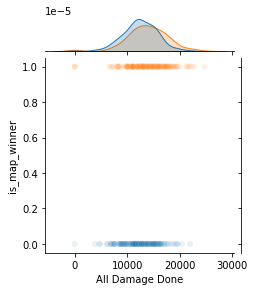

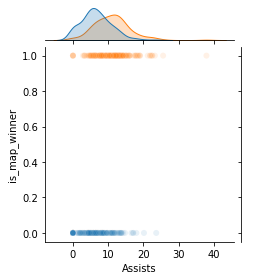

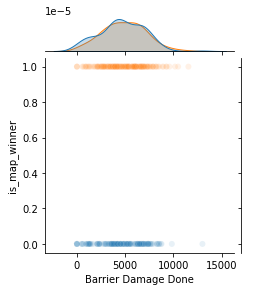

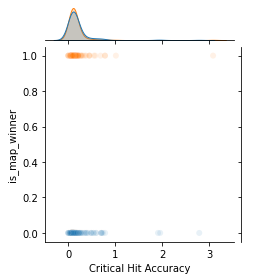

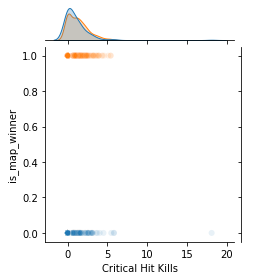

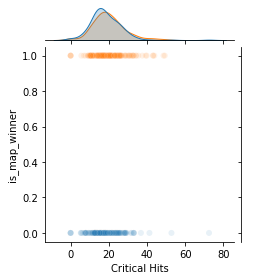

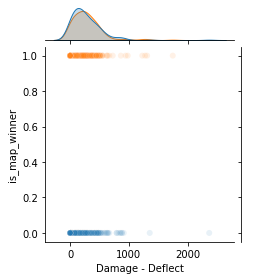

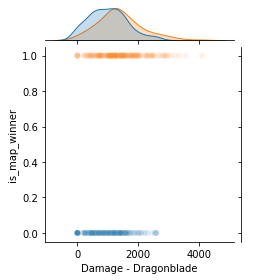

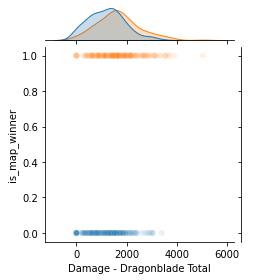

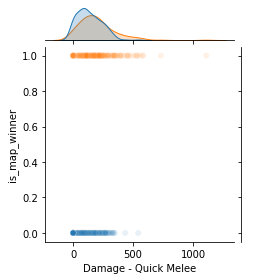

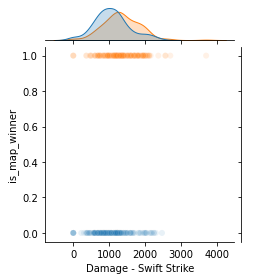

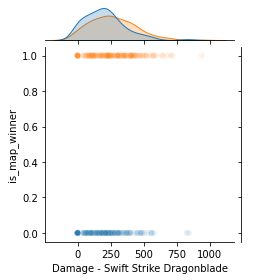

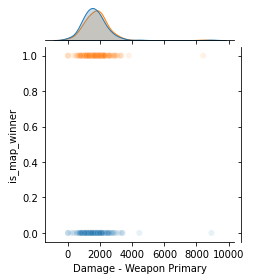

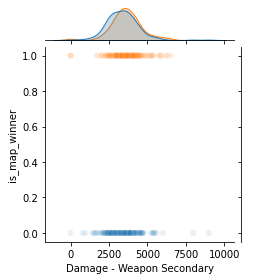

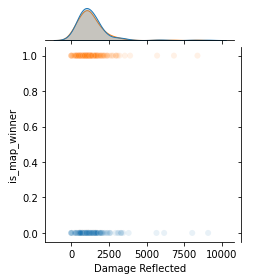

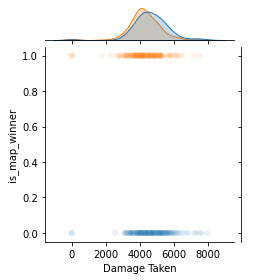

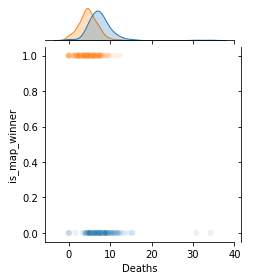

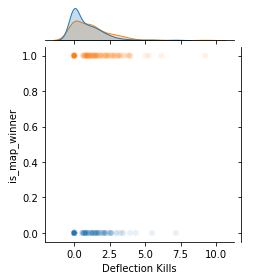

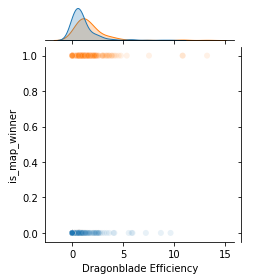

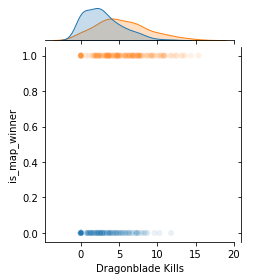

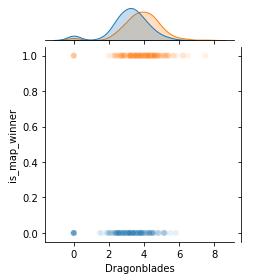

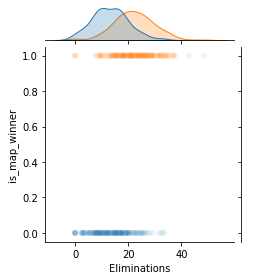

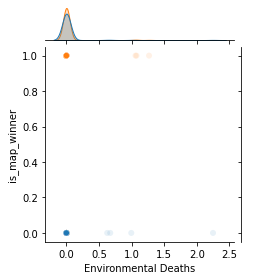

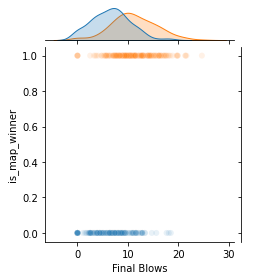

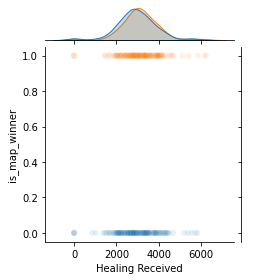

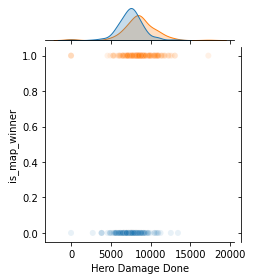

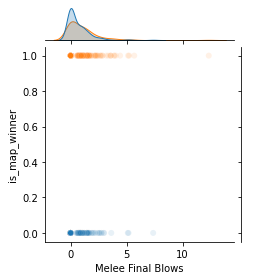

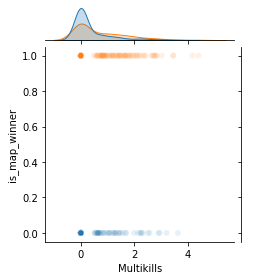

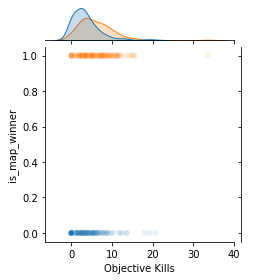

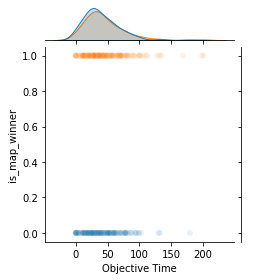

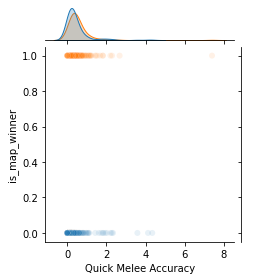

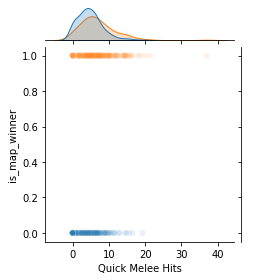

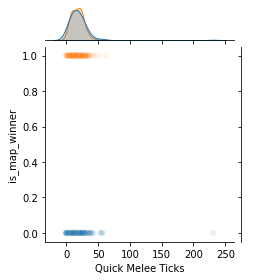

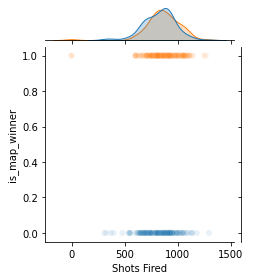

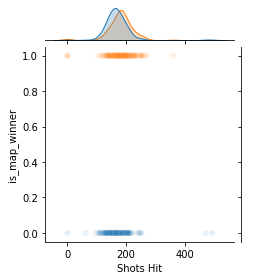

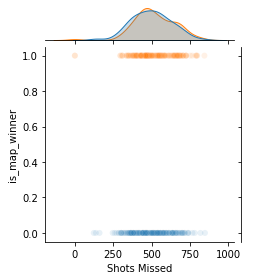

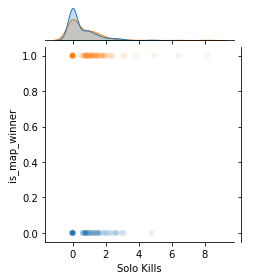

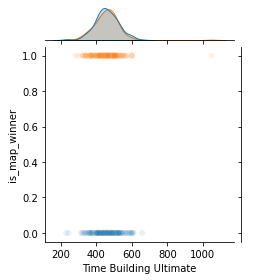

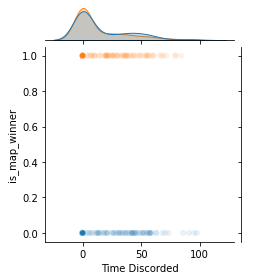

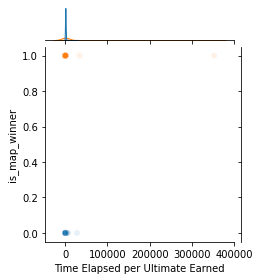

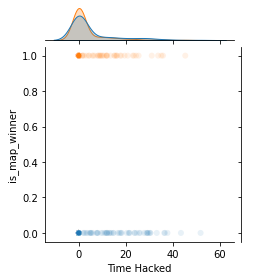

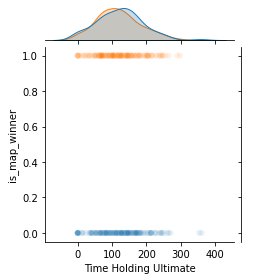

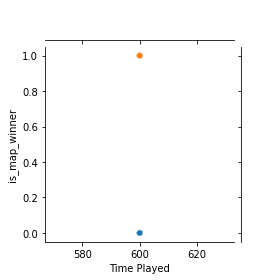

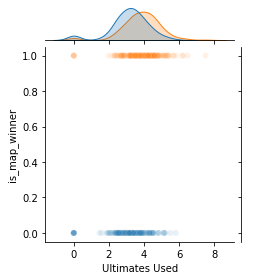

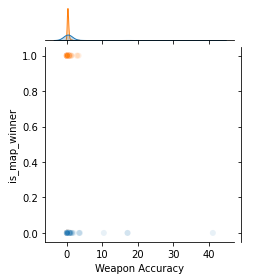

In [5]:
for f in X.columns:
    sns.jointplot(x=X[f], y=y, hue=y, height=4, legend=False, alpha=0.1)

# Data Modeling

In [6]:
# Import pakages for machine learning

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb

from keras.models import Sequential
from keras.layers import Dense

## 1. Logistic Regression

(301, 45) (76, 45) (301,) (76,)
Accuracy: 0.75


cols  abs_coef
42                 Time Played  0.000000
28             Objective Kills  0.005758
8   Damage - Dragonblade Total  0.019505
36                  Solo Kills  0.025480
40                 Time Hacked  0.045856

Text(0.6716750929821429, 0, 'accuracy: 0.75')

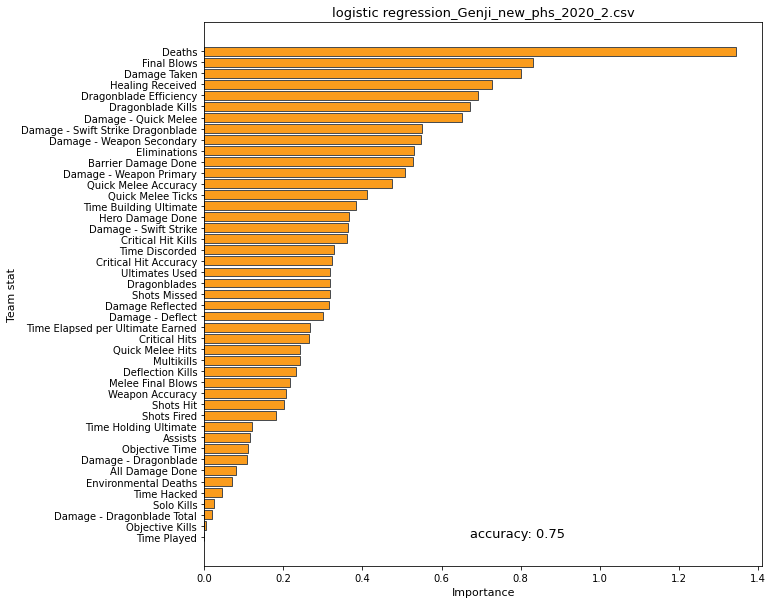

In [7]:
# Set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create the logistic regression model
log = LogisticRegression()
log.fit(X_train, y_train)

# Accuracy
accuracy = log.score(X_test, y_test)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# Get feature coefficient
coef = log.coef_[0]
# abs_coef = coef
abs_coef = abs(coef)

# summarize feature coefficient
fea_rank_ = pd.DataFrame({'cols': feature_names, 'abs_coef': abs_coef})
fea_rank_.sort_values(by=['abs_coef'], ascending = True, inplace=True)

display(fea_rank_.head())

# Plot feature coefficient
if all_seasons == True:
    title = f'logistic regression_{target_hero}_all seasons'
else:
    title = f'logistic regression_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['abs_coef'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Importance', fontsize=11)

plt.text(x=max(fea_rank_['abs_coef'])/2, y=min(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
# save_path = f'./result/{target_hero}/'
# os.makedirs(save_path, exist_ok=True)
# fea_rank_.to_csv(f'{save_path}{title}.csv')
# plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

Accuracy: 0.80
[False False  True False False False False False False False False  True
 False False False  True  True False  True  True  True  True False False
  True False False False False False  True False False False False False
 False False False False False False False False False]


Text(18.0, 44, 'accuracy: 0.80')

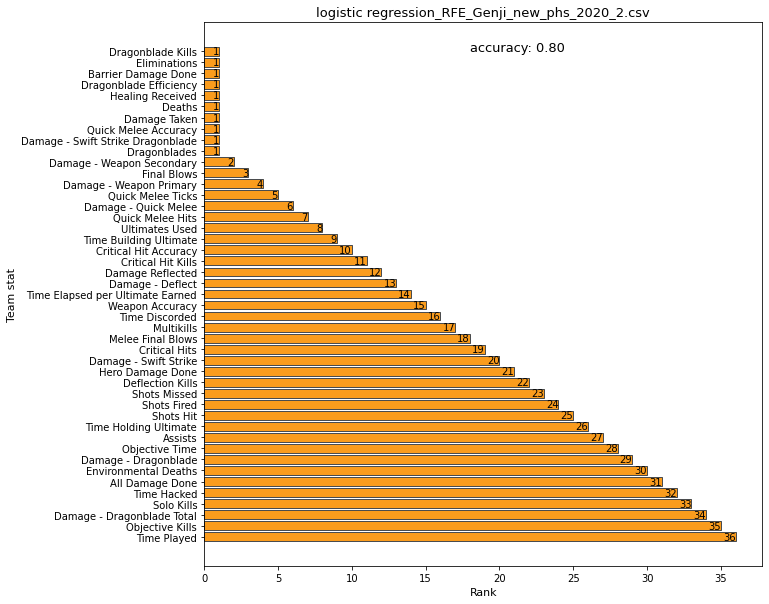

In [8]:
#Recursive Feature Elimination(RFE)

# create the RFE model
rfe = RFE(estimator=log, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# Accuracy
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# summarize the selection of the attributes
print(rfe.support_)

# summarize the ranking of the attributes
fea_rank_ = pd.DataFrame({'cols': feature_names, 'fea_rank': rfe.ranking_})
fea_rank_ = fea_rank_.loc[fea_rank_.fea_rank > 0].sort_values(by=['fea_rank'], ascending=False)

# Plot feature importance
if all_seasons == True:
    title = f'logistic regression_RFE_{target_hero}_all seasons'
else:
    title = f'logistic regression_RFE_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['fea_rank'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Rank', fontsize=11)

for i in fea_rank_.index: # add values on bar graph
   plt.text(fea_rank_.loc[i, 'fea_rank'], fea_rank_.loc[i, 'cols'], fea_rank_.loc[i, 'fea_rank'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_rank_['fea_rank'])/2, y=max(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

In [9]:
# reduce features
sel_features = fea_rank_[fea_rank_['fea_rank'] == 1]['cols']
sel_X = X[sel_features]
sel_y = y

(301, 10) (76, 10) (301,) (76,)
Accuracy: 0.75


cols  abs_coef
1  Damage - Swift Strike Dragonblade  0.223793
7                Barrier Damage Done  0.316219
0                       Dragonblades  0.465099
9                  Dragonblade Kills  0.477562
6             Dragonblade Efficiency  0.480093

Text(0.4955018125826725, 0, 'accuracy: 0.75')

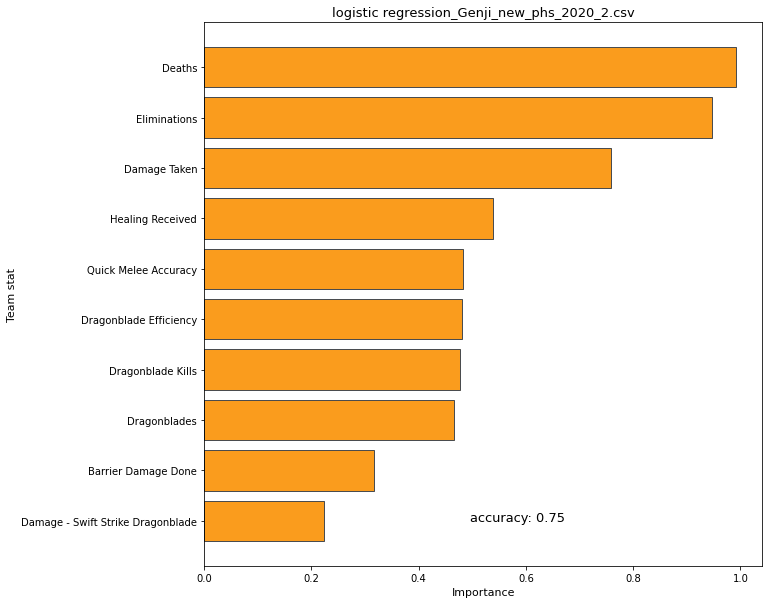

In [10]:
# Set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(sel_X, sel_y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create the logistic regression model
log = LogisticRegression()
log.fit(X_train, y_train)

# Accuracy
accuracy = log.score(X_test, y_test)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# Get feature coefficient
coef = log.coef_[0]
# abs_coef = coef
abs_coef = abs(coef)

# summarize feature coefficient
fea_rank_ = pd.DataFrame({'cols': feature_names, 'abs_coef': abs_coef})
fea_rank_.sort_values(by=['abs_coef'], ascending = True, inplace=True)

display(fea_rank_.head())

# Plot feature coefficient
if all_seasons == True:
    title = f'logistic regression_{target_hero}_all seasons'
else:
    title = f'logistic regression_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['abs_coef'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Importance', fontsize=11)

plt.text(x=max(fea_rank_['abs_coef'])/2, y=min(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

In [11]:
import shap

shap.initjs()

explainer = shap.LinearExplainer(log, X_train) # feature_perturbation='correlation_dependent'
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)
shap_values.shape

(76, 10)

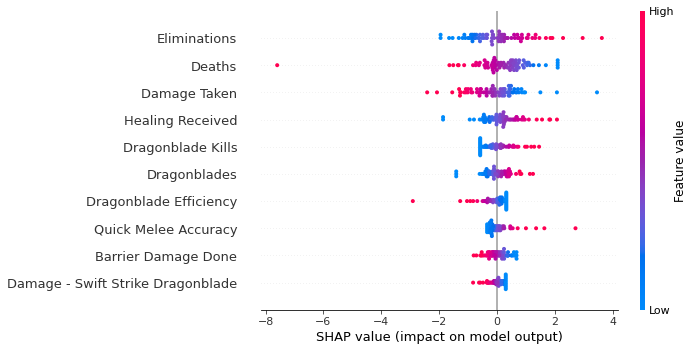

In [12]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

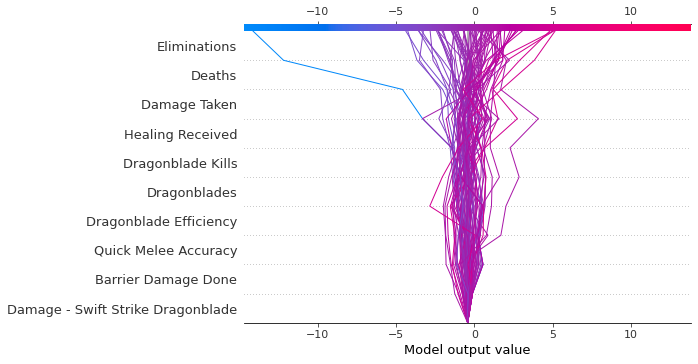

In [13]:
shap.decision_plot(expected_value, shap_values, feature_names)

## Player evaluation